In [1]:
!nvidia-smi

Thu Apr 26 19:22:36 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
| 23%   50C    P2    47W / 200W |    913MiB /  8118MiB |     19%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [5]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [6]:
input_shape = X_train.shape[1]

regulizer_value = 1e-4

hidden_layer = [10, 8, 4]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(input_layer)
encoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(encoder1)
encoder3 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(encoder2)
decoder1 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(encoder3)
decoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(decoder1)
decoder3 = Dense(input_shape, activation="relu", activity_regularizer=regularizers.l2(regulizer_value))(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 11)                99        
Total para

In [8]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE4.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard])

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 3137874684834.4448 - acc: 0.5300 - val_loss: 2750895757304.9590 - val_acc: 0.5495
Epoch 2/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2676372539656.3862 - acc: 0.5460 - val_loss: 2709595612823.4546 - val_acc: 0.5417
Epoch 3/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2641408529030.9668 - acc: 0.5454 - val_loss: 2669905141666.1719 - val_acc: 0.5620
Epoch 4/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2629789427868.8540 - acc: 0.5582 - val_loss: 2697982766732.3096 - val_acc: 0.5654
Epoch 5/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2625030144320.7373 - acc: 0.5564 - val_loss: 2656820019933.5640 - val_acc: 0.5546
Epoch 6/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2621953536917.8853 - acc: 0.5484

Epoch 50/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2207137049383.7920 - acc: 0.7803 - val_loss: 2335672250967.4204 - val_acc: 0.7305
Epoch 51/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2209007157856.9487 - acc: 0.7875 - val_loss: 2365588877500.0581 - val_acc: 0.7850
Epoch 52/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206742181379.4355 - acc: 0.7861 - val_loss: 2290882635986.4692 - val_acc: 0.7803
Epoch 53/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206891405273.6118 - acc: 0.7659 - val_loss: 2332196607441.9009 - val_acc: 0.7691
Epoch 54/200
4072076/4072076 [==============================] - 26s 6us/step - loss: 2207069796367.6172 - acc: 0.7698 - val_loss: 2304005527004.8447 - val_acc: 0.7411
Epoch 55/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2207948628161.4097 - acc: 0.7591 - val_loss: 2239426216708.1895 - val_acc: 0.809

4072076/4072076 [==============================] - 25s 6us/step - loss: 2207739470558.7476 - acc: 0.7742 - val_loss: 2326193580015.5439 - val_acc: 0.8119
Epoch 100/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206441123724.3120 - acc: 0.7946 - val_loss: 2304451796883.3657 - val_acc: 0.7544
Epoch 101/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206679298911.5518 - acc: 0.7876 - val_loss: 2415615889032.9297 - val_acc: 0.8052
Epoch 102/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2207568639715.9307 - acc: 0.7962 - val_loss: 2317812493657.2363 - val_acc: 0.7993
Epoch 103/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206966545814.2476 - acc: 0.7976 - val_loss: 2286913446777.8364 - val_acc: 0.7585
Epoch 104/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206881756040.5112 - acc: 0.7881 - val_loss: 2427725946794.8628 - val_acc: 0.8166
Epoch 

Epoch 148/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2207296675978.0142 - acc: 0.7605 - val_loss: 2250052611378.2886 - val_acc: 0.7343
Epoch 149/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2205493287268.6733 - acc: 0.7779 - val_loss: 2319516887443.5972 - val_acc: 0.7320
Epoch 150/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206542098998.2954 - acc: 0.7624 - val_loss: 2300329158334.7236 - val_acc: 0.7616
Epoch 151/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2206244021489.6084 - acc: 0.7676 - val_loss: 2341258704396.0000 - val_acc: 0.7422
Epoch 152/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2209945164994.2334 - acc: 0.7426 - val_loss: 2368917378799.0864 - val_acc: 0.6602
Epoch 153/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 2209685959745.6406 - acc: 0.7304 - val_loss: 2499338208069.5312 - val_acc:

4072076/4072076 [==============================] - 70s 17us/step - loss: 2207679707152.2285 - acc: 0.7514 - val_loss: 2402630204879.6074 - val_acc: 0.7416
Epoch 197/200
4072076/4072076 [==============================] - 69s 17us/step - loss: 2207743187194.3081 - acc: 0.7471 - val_loss: 2375690100217.6128 - val_acc: 0.7240
Epoch 198/200
4072076/4072076 [==============================] - 70s 17us/step - loss: 2207273045779.9048 - acc: 0.7340 - val_loss: 2404769793094.3911 - val_acc: 0.7162
Epoch 199/200
4072076/4072076 [==============================] - 67s 17us/step - loss: 2207165027369.4751 - acc: 0.7349 - val_loss: 2241928370796.6245 - val_acc: 0.7396
Epoch 200/200
4072076/4072076 [==============================] - 66s 16us/step - loss: 2207588946588.3398 - acc: 0.7318 - val_loss: 2317492118663.8936 - val_acc: 0.6258


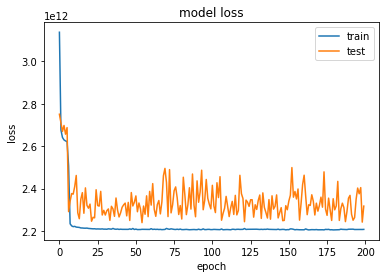

In [9]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE4.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
import numpy as np


predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.describe()
print(predictions.shape)

In [ ]:
print(predictions[0][:])
X_test.head(1)